In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #'warn'  # default='warn'
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.base import BaseEstimator,TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# from imblearn.over_sampling import SMOTENC
# from imblearn.combine import SMOTETomek
import phik
from pandas_profiling import ProfileReport
import optuna
import graphviz
from IPython import display as ipy_display

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
#     labelweight="bold",
    labelsize="Large",
#     titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plt.rc("legend",fontsize='large')
plt.rc("xtick", labelsize='large')
plt.rc("ytick", labelsize='large')

## Load data, join credit features 

In [2]:
pd.read_csv('data_dictionary.csv')

,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


In [3]:
app_sample = pd.read_csv('application_samples.csv')
app_sample

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success
0,216009,2020-01-01,7000.0,36,Employed - full time,Not Known,0
1,217537,2020-01-01,1000.0,60,Employed - full time,Not Known,0
2,221803,2020-01-01,2000.0,24,Employed - part time,Consolidation,0
3,222260,2020-01-01,4000.0,48,Employed - full time,Not Known,0
4,222848,2020-01-01,7000.0,60,Employed - full time,Not Known,0
...,...,...,...,...,...,...,...
8842,9679857,2020-12-31,10000.0,60,Employed - full time,House / Home improvement,0
8843,9680193,2020-12-31,3000.0,48,Employed - full time,Car,0
8844,9681405,2020-12-31,20000.0,36,Employed - full time,Car,0
8845,9684198,2020-12-31,2500.0,24,Employed - full time,Not Known,0


In [4]:
cred_feat = pd.read_csv('credit_features.csv')
cred_feat

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_TimeSinceMostRecentDefault,ALL_WorstPaymentStatusActiveAccounts
0,216009,227,12,14,11,0,3,0,3,71.36,9292,9292,-1,7
1,217537,49,10,7,6,1,3,1,1,29.33,4592,4592,-1,7
2,221803,134,0,12,11,0,3,5,1,32.33,2737,2737,-1,7
3,222260,227,2,39,12,0,2,2,27,41.56,9229,9229,-1,7
4,222848,132,2,99,11,8,0,9,88,43.34,15443,15443,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,9679857,399,13,23,16,0,0,0,7,118.09,187302,23018,-1,0
8843,9680193,217,23,5,4,0,0,0,1,85.40,264,264,-1,0
8844,9681405,3,1,2,2,0,0,2,0,2.00,0,0,-1,0
8845,9684198,178,15,23,17,0,1,0,6,66.91,10071,10071,-1,7


Make sure all IDs are unique and consistent across the two datasets.

In [5]:
print(app_sample.nunique().UID == len(app_sample))
print(cred_feat.nunique().UID == len(cred_feat))
print(set(app_sample.UID)==set(cred_feat.UID))

True
True
True


Use IDs as keys.

In [6]:
app_sample.set_index('UID', inplace=True)
cred_feat.set_index('UID', inplace=True)

In [7]:
dat = app_sample.join(cred_feat, on='UID', how='outer')
dat.isnull().sum().sum()

0

## Profiling Report 

**Quickly analyze univariate statistics, missing values, and correlations.**

In [8]:
prof = ProfileReport(dat)
prof.to_file(output_file='loans_profile.html')

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Inspect n/a values.**

In [9]:
nas = pd.concat([(dat==-1).sum(),(dat==0).sum(),
                 (dat==1).sum()], axis=1).loc['ALL_AgeOfOldestAccount':,:]
nas.columns = ['-1','0','1']
nas

,-1,0,1
ALL_AgeOfOldestAccount,108,0,2
ALL_AgeOfYoungestAccount,108,231,1089
ALL_Count,0,108,72
ALL_CountActive,116,0,120
ALL_CountClosedLast12Months,108,3205,2366
ALL_CountDefaultAccounts,108,5619,882
ALL_CountOpenedLast12Months,108,1790,2001
ALL_CountSettled,108,792,732
ALL_MeanAccountAge,108,0,2
ALL_SumCurrentOutstandingBal,108,345,3


* 108 applicants have never had an account, and 8 more have no active accounts
* ALL_TimeSinceMostRecentDefault columns is all -1 => should be removed

In [10]:
dat.drop('ALL_TimeSinceMostRecentDefault', axis=1, inplace=True)

Check if total count = active + settled:

In [11]:
x = dat.copy()
x.ALL_CountActive[x.ALL_CountActive==-1] = 0
x.ALL_CountSettled[x.ALL_CountSettled==-1] = 0
cond = (x.ALL_CountActive + x.ALL_CountSettled) == x.ALL_Count
cond.sum()==len(x)

True

Thus we can remove one redundant feature:

In [12]:
dat.drop('ALL_CountSettled', axis=1, inplace=True)

Make categories more concise:

In [13]:
dat.LoanPurpose.replace({
            'Not Known': 'n/a',
            'Consolidation': 'Consol',
            "House / Home improvement": 'Home_improv',
            }, inplace=True)
    
dat.EmploymentType.replace({
            'Employed - full time':'full', 
            'Employed - part time':'part', 
            'Self employed':'self',
            'Retired' :'ret'}, inplace=True)

In [14]:
dat

,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
UID,,,,,,,,,,,,,,,,,
216009,2020-01-01,7000.0,36,full,n/a,0,227,12,14,11,0,3,0,71.36,9292,9292,7
217537,2020-01-01,1000.0,60,full,n/a,0,49,10,7,6,1,3,1,29.33,4592,4592,7
221803,2020-01-01,2000.0,24,part,Consol,0,134,0,12,11,0,3,5,32.33,2737,2737,7
222260,2020-01-01,4000.0,48,full,n/a,0,227,2,39,12,0,2,2,41.56,9229,9229,7
222848,2020-01-01,7000.0,60,full,n/a,0,132,2,99,11,8,0,9,43.34,15443,15443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679857,2020-12-31,10000.0,60,full,Home_improv,0,399,13,23,16,0,0,0,118.09,187302,23018,0
9680193,2020-12-31,3000.0,48,full,Car,0,217,23,5,4,0,0,0,85.40,264,264,0
9681405,2020-12-31,20000.0,36,full,Car,0,3,1,2,2,0,0,2,2.00,0,0,0


## Approval / rejection counts across features

Power-transforms may not help tree-models, however they help analyze and visualize the data.

In [15]:
cols_log = ['Term', 'Amount',
            'ALL_AgeOfOldestAccount', 
            'ALL_AgeOfYoungestAccount',
            'ALL_Count', 
            'ALL_CountActive', 
            'ALL_CountClosedLast12Months',
            'ALL_CountDefaultAccounts', 
            'ALL_CountOpenedLast12Months',
            'ALL_MeanAccountAge',
            'ALL_SumCurrentOutstandingBal',
            'ALL_SumCurrentOutstandingBalExcMtg',   
            #'Amount_Outstanding', 'Term_Mtg', 'Term_Default'
           ]

In [16]:
dat_log = dat.copy()
dat_log[dat_log==-1] = np.nan
dat_log[cols_log] = np.log10(1.+dat_log[cols_log])

#### Duplicate successfull entries twice to see both outcomes clearer in the plots

<ipython-input-17-a8dbc699fdd3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes[3,3].set_xticklabels(dat_log.LoanPurpose.unique(), rotation=90)


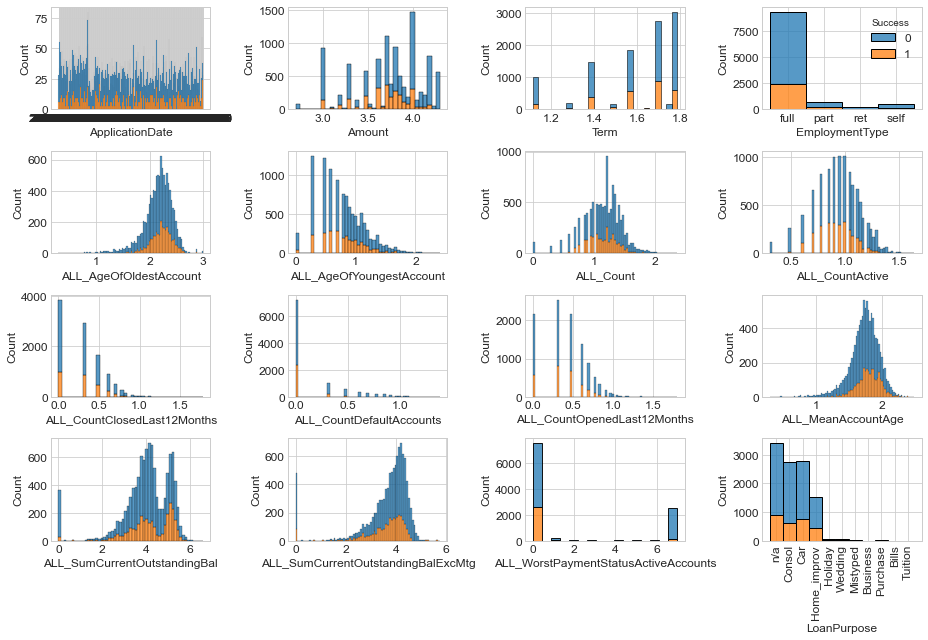

In [17]:
dat_log3 = pd.concat([dat_log, dat_log.loc[dat_log.Success==1,:], dat_log.loc[dat_log.Success==1,:]])
fig,axes = plt.subplots(4,4, figsize=(13,9))
cols2plot = dat.columns.to_list()
cols2plot.remove('Success')
cols2plot.remove('LoanPurpose')
cols2plot.append('LoanPurpose')
for n,col in enumerate(cols2plot):
    sns.histplot(data=dat_log3, x=col, hue='Success', 
                 multiple='stack', ax=axes[n//4,n%4], legend=(n==3))
_ = axes[3,3].set_xticklabels(dat_log.LoanPurpose.unique(), rotation=90)

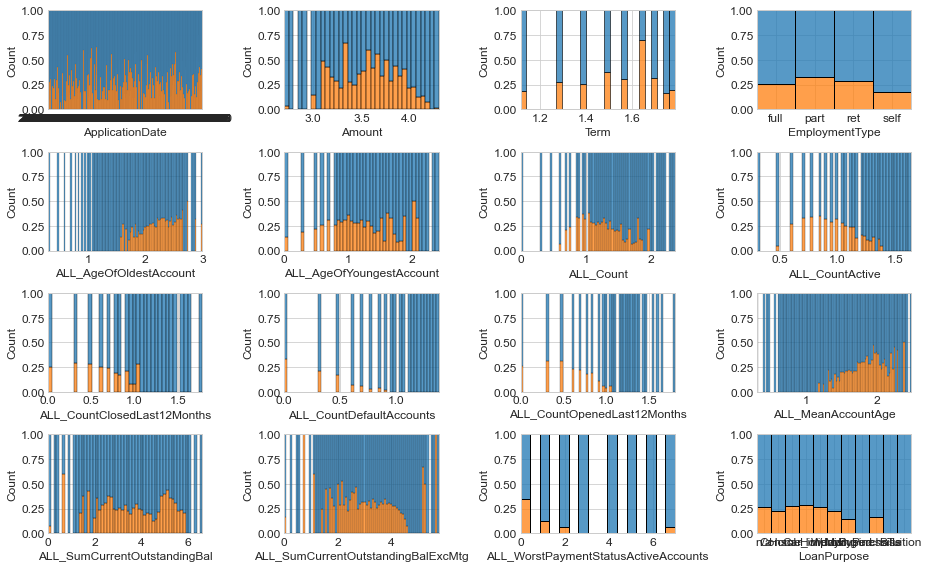

In [18]:
fig,axes = plt.subplots(4,4, figsize=(13,8))
for n,col in enumerate(cols2plot):
    sns.histplot(data=dat_log3, x=col, hue='Success', multiple='fill', ax=axes[n//4,n%4], legend=False)

We already see that some of the most distinguishing features should be `ALL_WorstPaymentStatusActiveAccounts`, `MeanAccountAge`, `CountDefaultAccounts`, and perhaps `Amount`.

## Correlations

### Linear, numerical features

Now let's look at interactions between the features and their correlation with the target. 

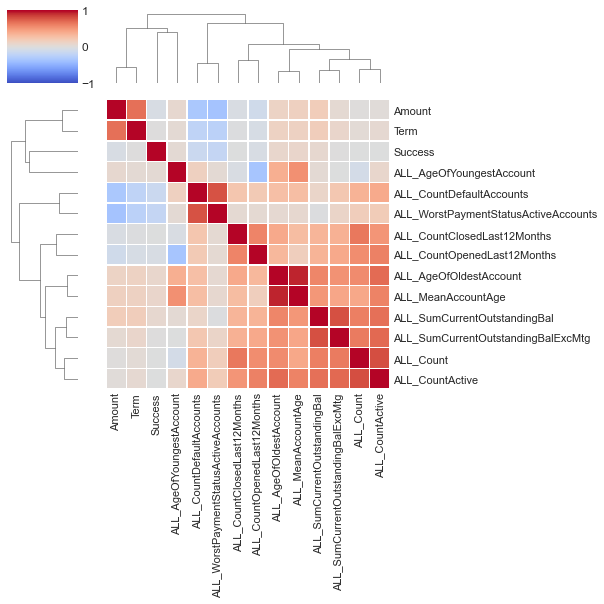

In [19]:
corr = dat_log.replace(np.nan,-1).corr() 
g = sns.clustermap(corr, cmap='coolwarm', 
                   vmin=-1.,vmax=1., center=0,
                   linewidths=.5, cbar_kws={"shrink": .5}, 
                   figsize=(8.5,8.5)) 
_=g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 11)
_=g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 11)

In [20]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 216009 to 9684478
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ApplicationDate                       8847 non-null   object 
 1   Amount                                8847 non-null   float64
 2   Term                                  8847 non-null   int64  
 3   EmploymentType                        8847 non-null   object 
 4   LoanPurpose                           8847 non-null   object 
 5   Success                               8847 non-null   int64  
 6   ALL_AgeOfOldestAccount                8847 non-null   int64  
 7   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 8   ALL_Count                             8847 non-null   int64  
 9   ALL_CountActive                       8847 non-null   int64  
 10  ALL_CountClosedLast12Months           8847 non-null   int64  
 11  ALL_Count

In [21]:
# non-discrete columns
interval_cols = set(dat.columns) - set(['ApplicationDate',
                                        'EmploymentType',
                                        'LoanPurpose',
                                        'Success',
                                        'ALL_WorstPaymentStatusActiveAccounts'
                                        ])

### PhiK correlation: works for discrete features and captures nonlinearities

<Figure size 720x720 with 0 Axes>

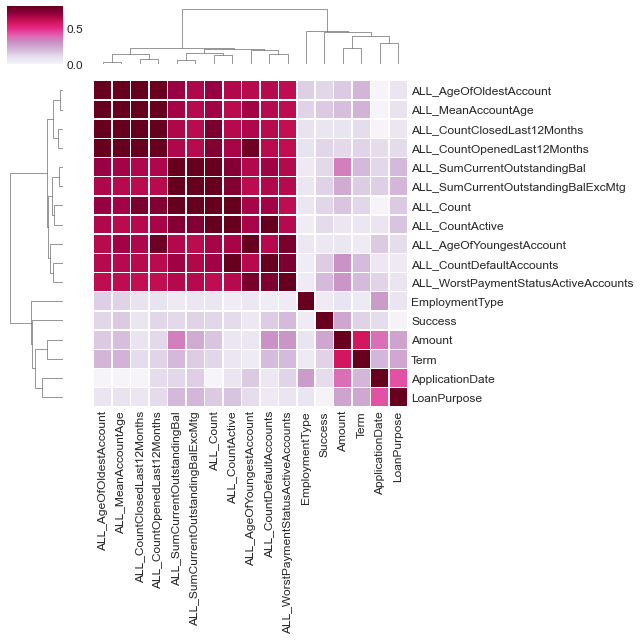

In [22]:
plt.figure(figsize=(10,10))
phik_overview = dat_log.replace(np.nan,-1).phik_matrix(interval_cols=interval_cols)
ax = sns.clustermap(phik_overview, figsize=(9,9),cmap='PuRd', vmin=0.,vmax=0.8,
                     linewidths=.5, cbar_kws={"shrink": .5}, dendrogram_ratio=0.15)

All credit features are strongly correlated, and the log transform enhances the correlation. Let's look at their interaction more closely by plotting pair-wise distribution functions.

### Correlations and approvals: Pairplot for continuous variables

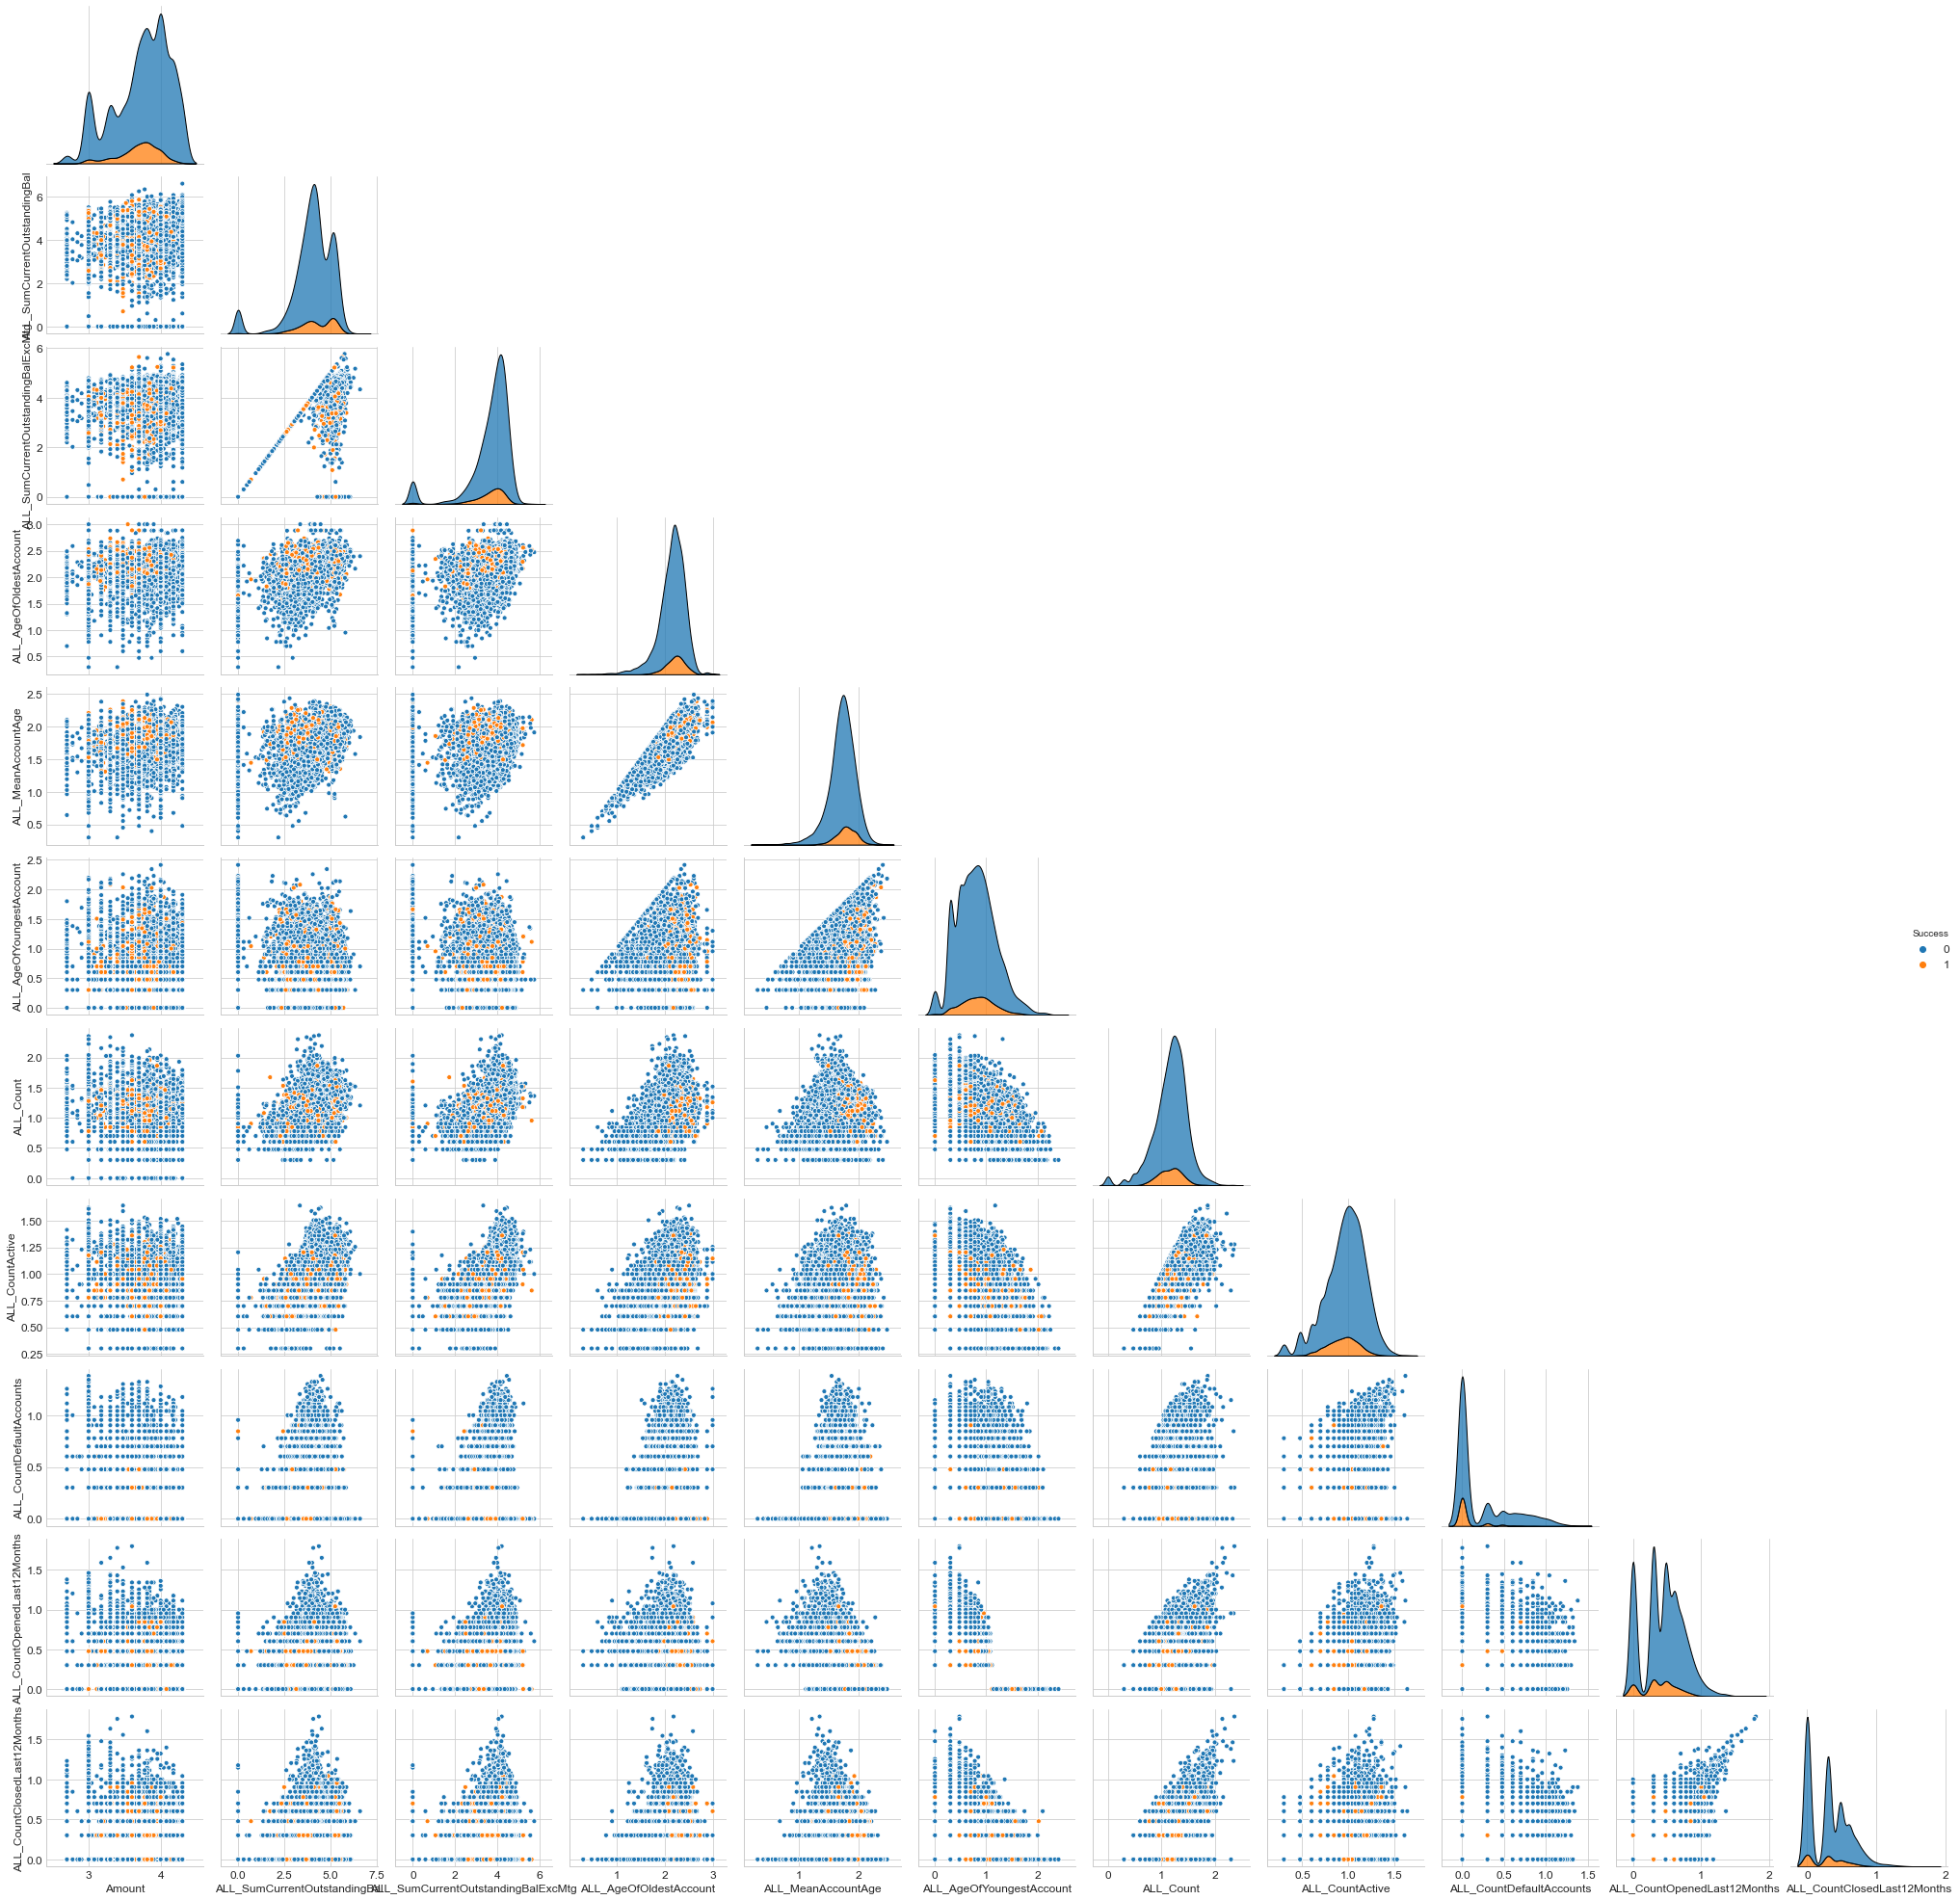

In [23]:
# dat_log2 = pd.concat([dat_log, dat_log.loc[dat_log.Success==1,:]])
# out_ind = (_dat[cols_out] < _dat[cols_out].mean() + 3*_dat[cols_out].std()).all(axis=1)
# _dat = _dat.loc[out_ind,:]

cols_pplot = [
    'Amount',
    'ALL_SumCurrentOutstandingBal',
    'ALL_SumCurrentOutstandingBalExcMtg',
    'ALL_AgeOfOldestAccount',
    'ALL_MeanAccountAge',
    'ALL_AgeOfYoungestAccount',
    'ALL_Count',
    'ALL_CountActive',
    'ALL_CountDefaultAccounts',
    'ALL_CountOpenedLast12Months',
    'ALL_CountClosedLast12Months',
    'Success',
]  

sns.pairplot(
    dat_log[cols_pplot], 
    hue='Success', plot_kws=dict(marker='.',s=100),
    kind='scatter', dropna=True,
    diag_kws={'multiple':'stack'}, 
    corner=True
    )

* Correlations related to the arithmetic of counts are clearly seen. 
* The outstanding balance grows with the number of accounts. 
* Successful applicants tend to have larger mean account age.
* Candidates with large numbers of opened/closed accounts (>10) within the last year are disfavoured.
* There seems to be a significant fraction of successful applicants with mortgage.
* As expected, a low number of default accounts is required for success.

### Correlations and approvals: Categorical plots for discrete features

Let's explore some of the correlations in the categorical features seen in the correlation matrix.<br>

**First, investigate `ALL_WorstPaymentStatusActiveAccounts`:** 

In [24]:
a = dat.ALL_WorstPaymentStatusActiveAccounts[dat.Success==0]
b = dat.ALL_WorstPaymentStatusActiveAccounts[dat.Success==1]
df = pd.concat([a.value_counts(), b.value_counts()], axis=1)
df.columns = ['Unsuccessful', 'Successful']
df.rename_axis('Status', axis='rows')

,Unsuccessful,Successful
Status,,
-1,116,NaN
0,4963,859.0
1,193,9.0
2,83,2.0
3,48,NaN
4,31,NaN
5,26,NaN
6,69,NaN
7,2396,52.0


<AxesSubplot:xlabel='ALL_WorstPaymentStatusActiveAccounts', ylabel='ALL_CountDefaultAccounts'>

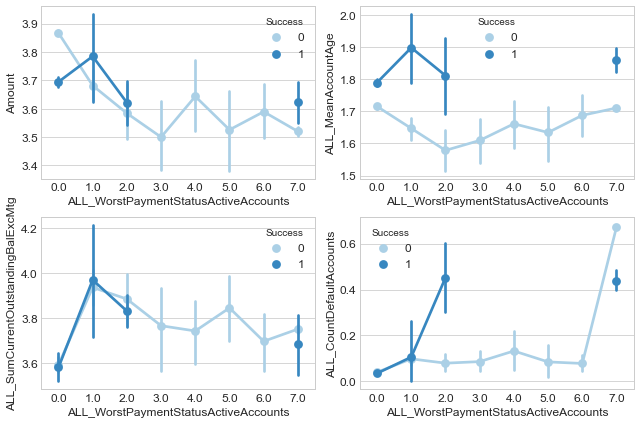

In [25]:
kw_args = dict(data=dat_log, x='ALL_WorstPaymentStatusActiveAccounts', hue='Success', palette='Blues')
#ymins = [1.5,2.75,3.,0.]

fig,axes = plt.subplots(2,2, figsize=(9,6))

sns.pointplot(y='Amount', ax=axes[0,0], **kw_args)
sns.pointplot(y='ALL_MeanAccountAge',ax=axes[0,1], **kw_args)
sns.pointplot(y='ALL_SumCurrentOutstandingBalExcMtg', ax=axes[1,0], **kw_args)
sns.pointplot(y='ALL_CountDefaultAccounts', ax=axes[1,1], **kw_args)
# for n in range(4):
#     axes[n//2,n%2].set_xticklabels(dat_log.Term.unique().round(2))
#     axes[n//2,n%2].set_ylim(ymin= ymins[n])

* Loan amounts get smaller, outstanding balance larger towards worse satus. 
* The default count is much larger in the worst category.

**Let's move on to `Term`:**

In [26]:
a = dat.Term[dat.Success==0]
b = dat.Term[dat.Success==1]
df = pd.concat([a.value_counts(), b.value_counts()], axis=1)
df.columns = ['Unsuccessful', 'Successful']
df.rename_axis('Term', axis='rows')

,Unsuccessful,Successful
Term,,
12,815,60
18,139,18
24,1109,124
30,104,21
36,1277,192
42,13,10
48,1883,290
54,141,9
60,2444,198


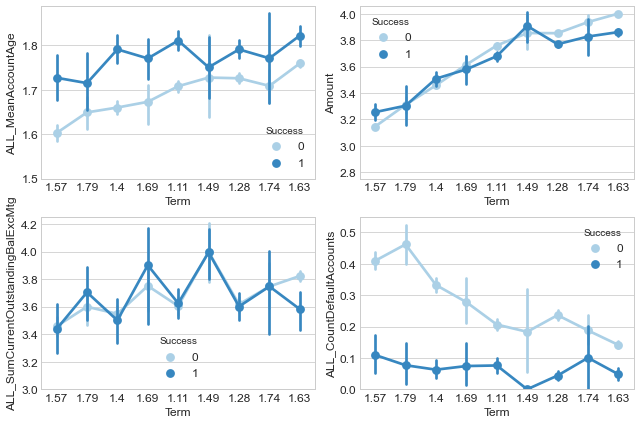

In [27]:
kw_args = dict(data=dat_log, x='Term', hue='Success', palette='Blues')
ymins = [1.5,2.75,3.,0.]

fig,axes = plt.subplots(2,2, figsize=(9,6))

sns.pointplot(y='ALL_MeanAccountAge', ax=axes[0,0], **kw_args)
sns.pointplot(y='Amount',ax=axes[0,1], **kw_args)
sns.pointplot(y='ALL_SumCurrentOutstandingBalExcMtg', ax=axes[1,0], **kw_args)
sns.pointplot(y='ALL_CountDefaultAccounts', ax=axes[1,1], **kw_args)
for n in range(4):
    axes[n//2,n%2].set_xticklabels(dat_log.Term.unique().round(2))
    axes[n//2,n%2].set_ylim(ymin= ymins[n])

* A longer mean account age is more favourable for approval, but this is slightly less so for longer-term loans. 
* The number of defaulted accounts of unsuccessful short-term borrowers is high. A consistently low number of defaults is necessary for sucess for any term.

**Finally, let's look at `LoanPurpose`:**

In [28]:
pd.concat([dat.groupby('LoanPurpose').Amount.mean(), dat.LoanPurpose.value_counts()], axis=1) 

,Amount,LoanPurpose
Bills,2000.000000,1
Business,14333.333333,3
Car,8623.211106,2269
Consol,8292.462687,2345
Holiday,4608.323077,65
Home_improv,7530.631789,1252
Mistyped,5121.621622,37
Purchase,4843.750000,16
Tuition,8000.000000,1
Wedding,8544.642857,56


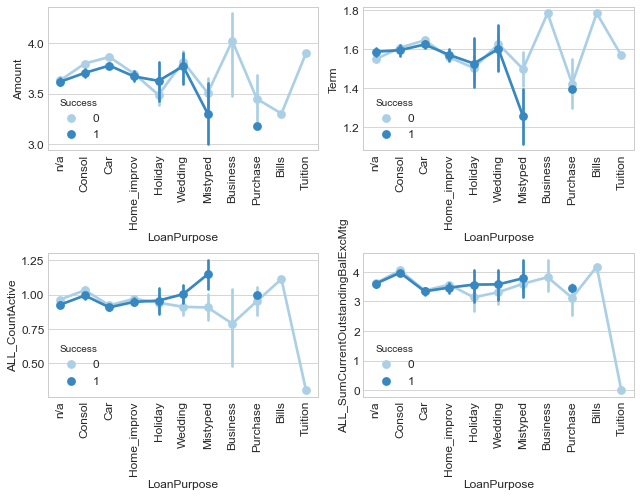

In [29]:
kw_args = dict(data=dat_log, x='LoanPurpose', hue='Success', palette='Blues')

fig,axes = plt.subplots(2,2, figsize=(9,7))
sns.pointplot(y='Amount', ax=axes[0,0], **kw_args)
sns.pointplot(y='Term', ax=axes[0,1], **kw_args)
sns.pointplot(y='ALL_CountActive', ax=axes[1,0], **kw_args)
sns.pointplot(y='ALL_SumCurrentOutstandingBalExcMtg', ax=axes[1,1], **kw_args)

for n in range(4):
    axes[n//2,n%2].set_xticklabels(dat_log.LoanPurpose.unique(), rotation=90)
    #axes[n//2,n%2].set_ylim(ymin= ymins[n])

There is no clear correlation between `LoanPurpose` and other features across the dominant categories (Car, Consolidation, home improv., n/a). Also no indication that the loan purpose affects decisions.

## Building a model

The dataset is imbalanced with the number of unsuccessful applicants about 8.6 times larger than the successful ones:
* Use metrics independent of the decision threshold: **average precision** and **ROC AUC**, in addition save **PR curves**. Precision should be more important than recall because it's worse to have risky applicants among our approval predictions than be more conservative and predict less approvals than possible.
* Try adjusting class weights in tree models to give more weight to the minority class.
* Try oversampling.

The ROC AUC score for an imbalanced problem is over-optimistic, because it will give us ~80% accuracy when all entries are classified as unsuccessful. However it still reflects imrovements in the model and is useful because it idicates how well we rank successful loans higher than unsuccessful ones. 

The average precision (or the area under the PR curve) is challenging to maximize because it shows how much intersection between our predicted positive entries and real positives there is. We need to select a small fraction of the dataset as successful loans, and this fraction needs to be as close as possible to the small fraction of labeled positives.

With metrics independent of decision thresholds, we can probably skip adjusting class weights in tree models, because a similar effect can be achieved by lowering the decision treshold, so that more entries can be classified as positive (increasing recall). But our metric already provides precision integrated over thresholds. 

#### Make a simple pipeline that we will later modify step by step

In [32]:
# use label encoder (works for tree models)
pre_col_trans = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value',
                                                        unknown_value=-1), 
                                         make_column_selector(dtype_exclude=np.number)), 
                                         remainder='passthrough')
pipe = Pipeline([('preprocess',pre_col_trans), ('model',tree.DecisionTreeClassifier())])

#### Separate a test set used for final predictions

Keep the target inside the dataset.

In [33]:
dat_valid, dat_test, _,_ = train_test_split(dat,dat['Success'], 
                                            test_size=0.2, random_state=30)

### Score the dataset

In [34]:
def score_valid(dvalid, pipe, oversample=False, 
                  n_splits=5, remove_outliers=False, 
                  out_nstd=6., random_state=42, tree_model=True):
    """
    Evaluate a model on the dataset using cross-validation.
    """
    
#     cat_cols_loc = [X.columns.get_loc(col) for col in X.select_dtypes(exclude=np.number).columns]
#     smote = SMOTENC(categorical_features=cat_cols_loc, random_state=1)
            
    X=dvalid.copy()
    y=X.pop('Success')
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    scores_ap = {}
    scores_ap['train'] = []
    scores_ap['valid'] = []
    scores_roc = {}
    scores_roc['train'] = []
    scores_roc['valid'] = []
    precs = []    
    mean_rec = np.linspace(0,1,200)
    fi = []
    n=0
    #cm = np.zeros((2,2))
    
    for train_index, valid_index in kf.split(X,y):
        X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if oversample:
            X_train = pd.concat([X_train, X_train[y_train==1].sample(n=7000,replace=True)])
            y_train = pd.concat([y_train, pd.Series(np.ones(7000))])
#             X_train, y_train = smote.fit_resample(X_train, y_train)

        # remove extreme outliers (shouldn't be very important for trees)
        if remove_outliers:
            cols_out = X_train.select_dtypes(include=np.number).columns
            out_ind = (X_train[cols_out] < X_train[cols_out].median() 
                                         + out_nstd*X_train[cols_out].std()).all(axis=1)
            X_train = X_train.loc[out_ind,:]
            y_train = y_train.loc[out_ind]
            
        pipe.fit(X_train,y_train) 
        y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
        y_pred_prob = pipe.predict_proba(X_valid)[:,1]
        
        # feature importance
        if tree_model:
            fi.append(pipe['model'].feature_importances_ / n_splits)
            
        # average precision
        scores_ap['train'].append(metrics.average_precision_score(y_train,y_pred_train_prob))
        scores_ap['valid'].append(metrics.average_precision_score(y_valid,y_pred_prob))
        # ROC AUC score
        scores_roc['train'].append(metrics.roc_auc_score(y_train,y_pred_train_prob))
        scores_roc['valid'].append(metrics.roc_auc_score(y_valid,y_pred_prob))
        # precision-recall curve
        prec,rec,thr =  metrics.precision_recall_curve(y_valid,y_pred_prob)
        interp_prec = np.interp(mean_rec, rec[::-1], prec[::-1])
        interp_prec[0] = 0.0
        precs.append(interp_prec)
        n += 1
        
        # confusion matrix
#         y_pred = np.zeros_like(y_pred_prob)
#         y_pred[y_pred_prob>=threshold] = 1
#         y_pred[y_pred_prob<threshold] = 0
#         cm += metrics.confusion_matrix(y_test, y_pred)
    
    print('training AP score: {:.4f}+-{:.4f}'.format(np.mean(scores_ap['train']), 
                                                     np.std(scores_ap['train'])))
    print('training ROC score: {:.4f}+-{:.4f}'.format(np.mean(scores_roc['train']), 
                                                     np.std(scores_roc['train'])))
    print('------------------')
    print('validation AP score: {:.4f}+-{:.4f}'.format(np.mean(scores_ap['valid']), 
                                                     np.std(scores_ap['valid'])))
    print('validation ROC score: {:.4f}+-{:.4f}'.format(np.mean(scores_roc['valid']), 
                                                     np.std(scores_roc['valid'])))
#     cmp = pd.DataFrame(cm, index=['neg','pos'], columns=['neg','pos'])
#     cmp = cmp.rename_axis('pred', axis='columns')
#     cmp = cmp.rename_axis('true', axis='rows')
#     print(f'confusion matrix at threshold={threshold}:')
#     display(cmp)
    fi_mean = np.mean(fi,axis=0) if tree_model else None
    return scores_ap,scores_roc, {'mean_rec':mean_rec, 'prec':precs}, fi_mean


def score_test(dtrain, dtest, pipe, threshold=0.5):
    """
    Fit on train set, predict on test. 
    This can be done after cross-validation to see if 
    the model generalizes well. The test set should be 
    kept separately from the one used in cross-validation.
    """
    X_train = dtrain.copy()
    y_train = X_train.pop('Success')
    X_test = dtest.copy()
    y_test = X_test.pop('Success')
    pipe.fit(X_train,y_train)
    
    mean_rec = np.linspace(0,1,200)
    
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_pred = (y_pred_prob>threshold).astype(int)
    
    score_prec = metrics.precision_score(y_test,y_pred)
    score_rec  = metrics.recall_score(y_test,y_pred)
    
    score_ap  = metrics.average_precision_score(y_test, y_pred_prob)
    score_roc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    # precision-recall curve
    prec,rec,thr =  metrics.precision_recall_curve(y_test,y_pred_prob)
    interp_prec = np.interp(mean_rec, rec[::-1], prec[::-1])
    interp_prec[0] = 0.0
    
    print(f'test AP: {score_ap:.4f}')
    print(f'test ROC: {score_roc:.4f}')
    print(f'test precision: {score_prec:.4f}')
    print(f'test recall: {score_rec:.4f}')
    return ( y_pred, {'ap':score_ap, 'roc':score_roc, 'prec':score_prec, 'rec':score_rec}, 
                     {'mean_rec':mean_rec, 'prec':[interp_prec]} )


def plot_pr_curve(pr, ax=None, lbl=None, show_errors=True):
    """
    Plot precision-recall curve
    """
    mean_prec = np.mean(pr['prec'], axis=0)
    std_prec = np.std(pr['prec'], axis=0)
    if ax is None: fig,ax = plt.subplots(1,1)
    ax.plot(pr['mean_rec'], mean_prec, label=lbl)
    ax.plot(pr['mean_rec'], 0.116*np.ones_like(pr['mean_rec']), 'k--', lw=1.)
    if show_errors:
        ax.fill_between(pr['mean_rec'], mean_prec-std_prec, mean_prec+std_prec, alpha=0.3)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim(ymax=1,ymin=0)
    ax.legend()
    
def feature_names(dat):
    """
    Our pipeline rearranges the features. Use this function to get 
    the list of features in the order they are fed to the model.
    """
    cols = (dat.select_dtypes(exclude=np.number).columns.to_list() 
          + dat.select_dtypes(include=np.number).columns.to_list())
    cols.remove('Success')
    return cols

### Decision Tree

Try a simple decision tree and visualize it to gain more insight.

In [35]:
# choose parameters by hand to reduce overfitting
pipe.steps[-1] = ['model', tree.DecisionTreeClassifier(
                            max_depth=8, 
                            min_samples_split=300, 
                            min_samples_leaf=250,
                            #class_weight='balanced'
                            )]
_ = score_valid(dat_valid, pipe)

training AP score: 0.3570+-0.0049
training ROC score: 0.8440+-0.0028
------------------
validation AP score: 0.3490+-0.0173
validation ROC score: 0.8284+-0.0104


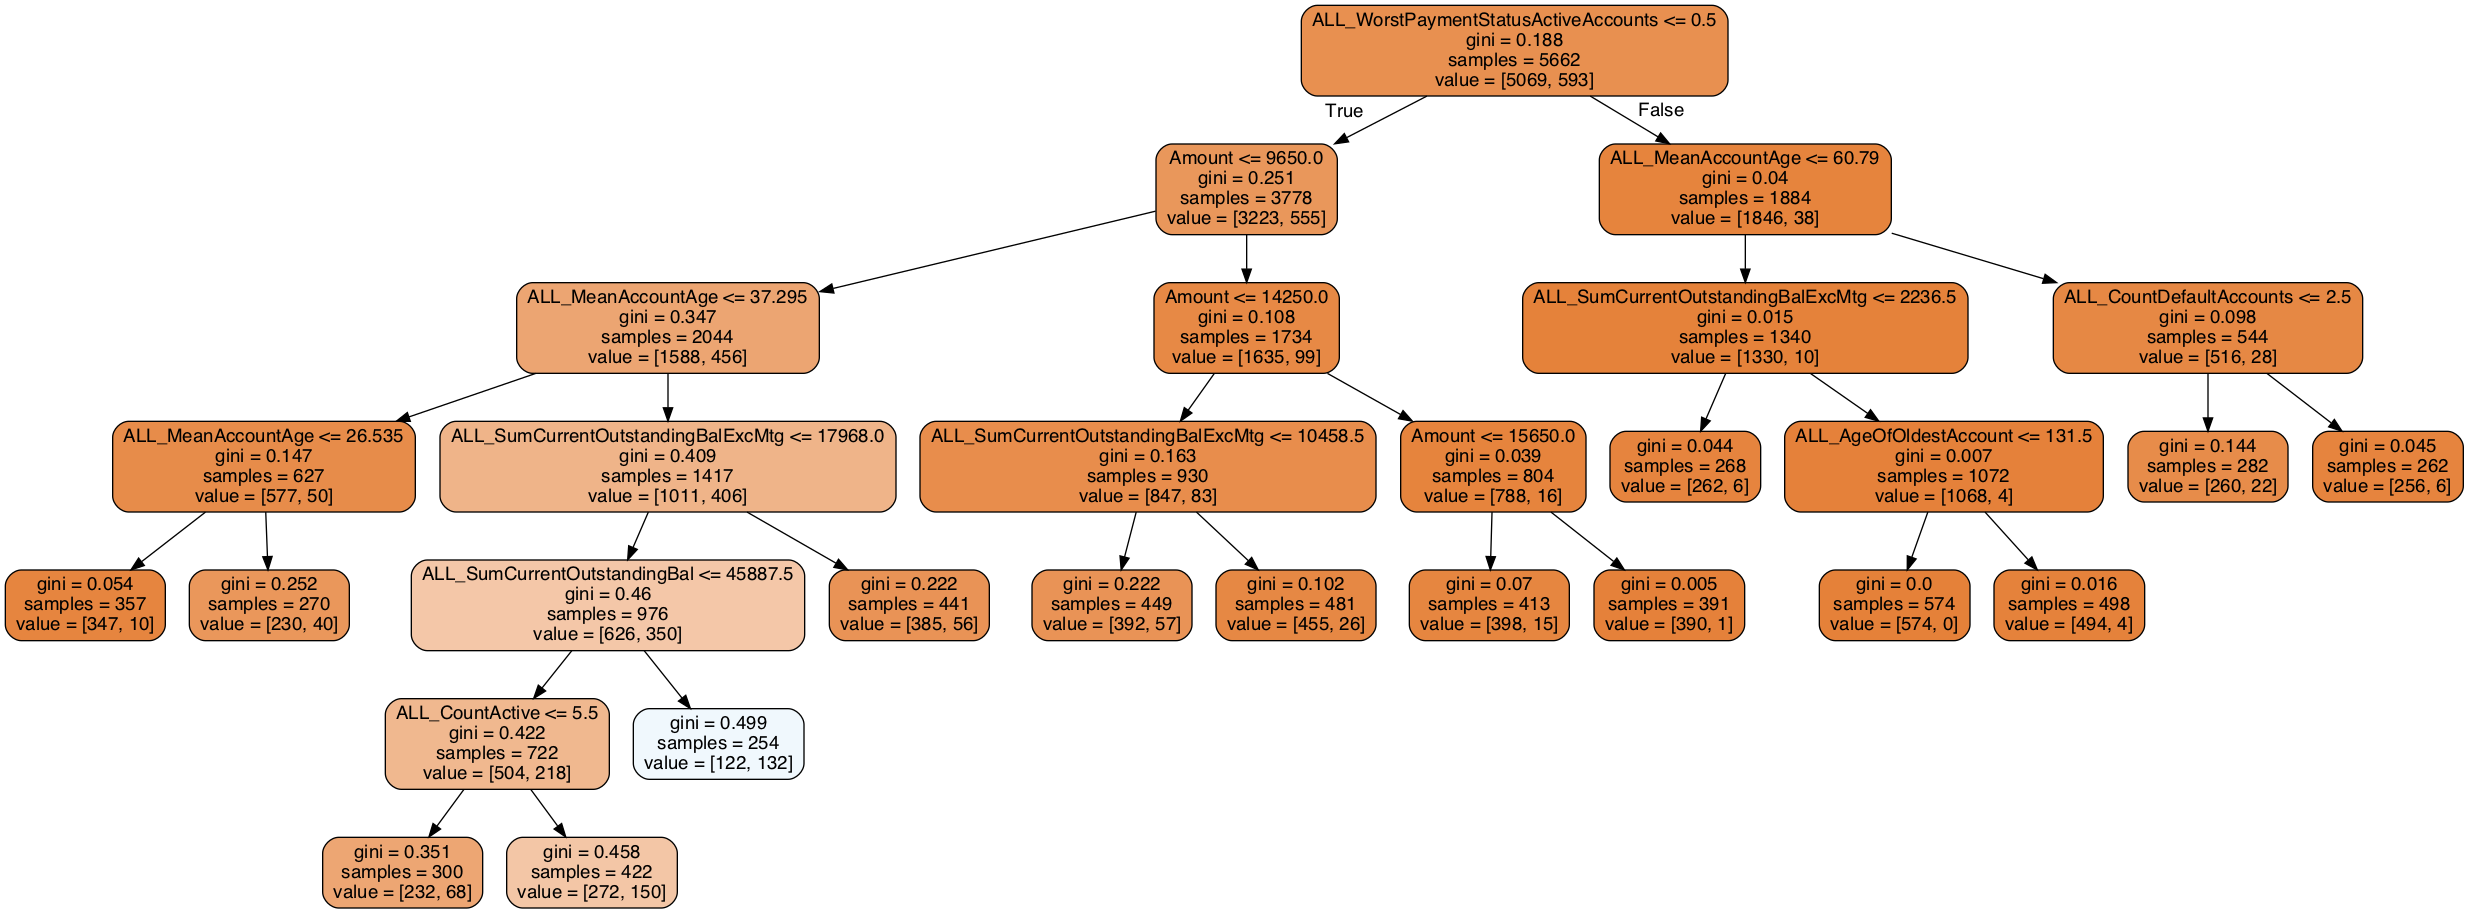

In [36]:
dot_data = tree.export_graphviz(pipe['model'],
                                feature_names=feature_names(dat_valid),
                                rounded=True, max_depth=6,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree_graphivz")
ipy_display.Image("decision_tree_graphivz.png", width=1600,height=900)

The tree clearly demonstrates the importance of features we have identified before: `WorstPaymentStatus`, `MeanAccountAge`, `CountDefaultAccounts`, `OutstandingBal`, and `Amount`.

### Random forest, class weights / oversampling, feature importance

Adjust parameter by hand to optimize the validation scores.

In [37]:
rf_params = dict(
            n_estimators=400,
            min_samples_split=50,
            max_features=4,
            min_samples_leaf=20,
            max_depth=9,
            random_state=42,
            n_jobs=-1
            )

In [38]:
pipe.steps[-1] = ['model', RandomForestClassifier(**rf_params)]
scores_ap,scores_roc, pr_rf, fi = score_valid(dat_valid, pipe)

training AP score: 0.6073+-0.0058
training ROC score: 0.9257+-0.0022
------------------
validation AP score: 0.4561+-0.0257
validation ROC score: 0.8658+-0.0139


Try **oversampling the training set** (inside the cross-validation loop) by adding more positive entries via bootstrap. The goal is to synthesize a balanced training set. 

In [39]:
_ = score_valid(dat_valid, pipe, oversample=True)

training AP score: 0.9405+-0.0023
training ROC score: 0.9329+-0.0025
------------------
validation AP score: 0.4321+-0.0366
validation ROC score: 0.8638+-0.0163


There doesn't seem to by much improvement. Slightly more elaborated sampling using SMOTE gives similar results.

Now let's try using the `class_weight` parameter to give more weight to the positive samples.

In [40]:
pipe['model'].set_params(class_weight='balanced')
_ = score_valid(dat_valid, pipe)

training AP score: 0.5651+-0.0063
training ROC score: 0.9210+-0.0022
------------------
validation AP score: 0.4444+-0.0303
validation ROC score: 0.8671+-0.0159


This gives only a modest increase of the ROC score. Therefore simply using a threshold-independent metric is probably enough. Later we can try switching `class_weight` on and off if there's imrovement.

### Feature importance from random forest

<AxesSubplot:>

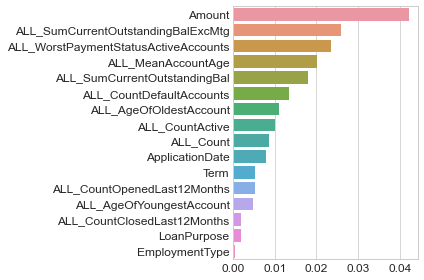

In [41]:
fi = pd.Series(fi, index=feature_names(dat_valid)).sort_values(ascending=False)
sns.barplot(x=fi.values, y=fi.index, orient='h')

### XGBoost

In [42]:
# parameters found empirically + using optuna
xgb_params = dict(
    use_label_encoder=False,
    n_jobs=8,
    verbosity = 0,
    learning_rate = 2e-2, 
    n_estimators = 200, 
    max_depth = 7, 
    min_child_weight = 7, 
    subsample = 0.6,
    #gamma=0.05
#     subsample = 0.3,
#     reg_lambda=1.1,
#     reg_alpha=1e-4
    )

For XGBoost setting the class weight to 8.6 often increases the average precision. 

In [43]:
pipe.steps[-1] = ['model', XGBClassifier(**xgb_params, scale_pos_weight=8.6)]
scores_ap,scores_roc, pr_xgb, fi = score_valid(dat_valid, pipe)

training AP score: 0.6959+-0.0079
training ROC score: 0.9530+-0.0017
------------------
validation AP score: 0.4638+-0.0292
validation ROC score: 0.8711+-0.0155


### PR curves 

Compare precision-recall curves for random forest and XGBoost:

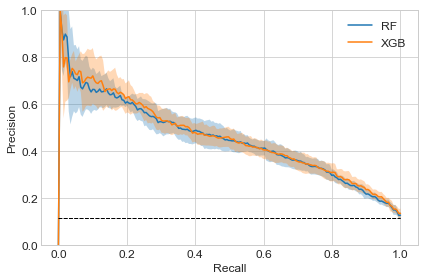

In [44]:
fig,ax = plt.subplots(1,1)
plot_pr_curve(pr_rf, ax=ax, lbl='RF')
plot_pr_curve(pr_xgb, ax=ax, lbl='XGB')

The dotted line shows a model with no skill that predicts all positives.

### Adding new features

In [45]:
def add_new_features(X_):
    
    X = X_.copy()

    # convert dates to pandas datetime
#     X.ApplicationDate = pd.to_datetime(X.ApplicationDate, infer_datetime_format=True)
#     X.EmploymentType = X.EmploymentType.astype('category')
#     X.LoanPurpose = X.LoanPurpose.astype('category')
    
    ind = (X.ALL_SumCurrentOutstandingBalExcMtg==-1) | (X.ALL_SumCurrentOutstandingBalExcMtg==0)
    X['Amount_Outstanding'] = X.Amount / X.ALL_SumCurrentOutstandingBalExcMtg
    X.loc[ind,'Amount_Outstanding'] = -1
    
    ind = X.ALL_Count==0
    X['Term_Mtg'] = X.Term * (X.ALL_SumCurrentOutstandingBal > X.ALL_SumCurrentOutstandingBalExcMtg) 
    X.loc[ind,'Term_Mtg']=-1
        
#     ind = X.ALL_CountDefaultAccounts==-1
#     X['Term_Default'] = X.Term * X.ALL_CountDefaultAccounts
#     X.loc[ind,'Term_Default'] = -1
    
    # mortgage amount
#     ind = X.ALL_SumCurrentOutstandingBalExcMtg==-1
#     X['Mtg'] = ((X.ALL_SumCurrentOutstandingBal > X.ALL_SumCurrentOutstandingBalExcMtg) * 
#                   (X.ALL_SumCurrentOutstandingBal - X.ALL_SumCurrentOutstandingBalExcMtg))
#     X.loc[ind,'Mtg'] = -1
    
    return X

Add new features to the validation and test datasets:

In [46]:
dat_valid_nf = add_new_features(dat_valid)
dat_test_nf = add_new_features(dat_test)

In [67]:
pipe.steps[-1] = ['model', RandomForestClassifier(**rf_params)]
_,_,_,fi = score_valid(dat_valid_nf, pipe)

training AP score: 0.6161+-0.0042
training ROC score: 0.9278+-0.0018
------------------
validation AP score: 0.4586+-0.0218
validation ROC score: 0.8649+-0.0151


In [68]:
pipe.steps[-1] = ['model', XGBClassifier(**xgb_params, scale_pos_weight=8.6)]
_ = score_valid(dat_valid_nf, pipe)

training AP score: 0.7053+-0.0076
training ROC score: 0.9550+-0.0018
------------------
validation AP score: 0.4682+-0.0207
validation ROC score: 0.8701+-0.0155


<AxesSubplot:>

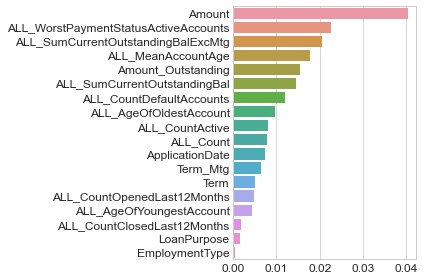

In [69]:
fi = pd.Series(fi, index=feature_names(dat_valid_nf)).sort_values(ascending=False)
sns.barplot(x=fi.values, y=fi.index, orient='h')

### Removing some features

We can try removing a few least important features. The following features are found by hand.

In [50]:
pipe.steps[-1] = ['model', RandomForestClassifier(**rf_params)]
_,_,_,fi = score_valid(dat_valid_nf.drop(['ALL_AgeOfYoungestAccount',
                                            'LoanPurpose',
                                       ], axis=1) , pipe)

training AP score: 0.6055+-0.0052
training ROC score: 0.9262+-0.0019
------------------
validation AP score: 0.4609+-0.0167
validation ROC score: 0.8652+-0.0153


In [51]:
pipe.steps[-1] = ['model', XGBClassifier(**xgb_params, scale_pos_weight=8.6)]
_ = score_valid(dat_valid_nf.drop(['ALL_AgeOfYoungestAccount', 
                               'ALL_CountClosedLast12Months',
                               'EmploymentType',
                               ],axis=1), pipe)

training AP score: 0.6938+-0.0055
training ROC score: 0.9526+-0.0014
------------------
validation AP score: 0.4689+-0.0227
validation ROC score: 0.8698+-0.0152


# Final predictions

In [52]:
# choose model
pipe.steps[-1] = ['model', XGBClassifier(**xgb_params, scale_pos_weight=8.6)]

features2drop = ['ALL_AgeOfYoungestAccount', 
                 'ALL_CountClosedLast12Months',
                 'EmploymentType']
# features2drop = ['ALL_AgeOfYoungestAccount',
#                  'LoanPurpose']

dat_train_nf_dr = dat_valid_nf.drop(features2drop, axis=1)
dat_test_nf_dr = dat_test_nf.drop(features2drop, axis=1)

In [53]:
results = score_test(dat_train_nf_dr, dat_test_nf_dr, pipe, threshold=0.8)

test AP: 0.4619
test ROC: 0.8651
test precision: 0.4724
test recall: 0.3315


By adjusting the threshold, we can set the desired ratio of precision to recall, where both lie on the PR curve:

No handles with labels found to put in legend.


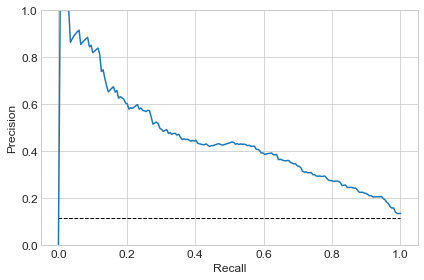

In [54]:
plot_pr_curve(results[2])

## Compare with Logistic regression and SVM

In [60]:
cols_log = ['Term', 'Amount',
            'ALL_AgeOfOldestAccount', 
            'ALL_AgeOfYoungestAccount',
            'ALL_Count', 
            'ALL_CountActive', 
            'ALL_CountClosedLast12Months',
            'ALL_CountDefaultAccounts', 
            'ALL_CountOpenedLast12Months',
            'ALL_MeanAccountAge',
            'ALL_SumCurrentOutstandingBal',
            'ALL_SumCurrentOutstandingBalExcMtg',   
            'Amount_Outstanding', 'Term_Mtg'
           ]
# log-transform
dat_valid_log = dat_valid_nf.copy()
dat_valid_log.replace(-1,np.nan, inplace=True)
dat_valid_log[cols_log] = np.log10(1 + dat_valid_log[cols_log])
dat_valid_log.replace(np.nan, -1, inplace=True)

dat_valid_log.drop('ApplicationDate', axis=1, inplace=True)

# apply one-hot encoder to categoricals, scaler to numerical features
ct = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), 
                make_column_selector(dtype_exclude=np.number)),
        (StandardScaler(),
                make_column_selector(dtype_include=np.number)),
        remainder='passthrough')

# make pipelines
pipe_lin = Pipeline([
        ('preprocess',ct),
        ('model', LogisticRegression(C=0.6))
         ])
pipe_svm = Pipeline([
        ('preprocess',ct),
        ('model', SVC(C=0.01, probability=True))
         ])

In [61]:
_,_,_,fi = score_valid(dat_valid_log, pipe_lin, tree_model=False)

training AP score: 0.2863+-0.0089
training ROC score: 0.7954+-0.0028
------------------
validation AP score: 0.2821+-0.0295
validation ROC score: 0.7887+-0.0109


In [62]:
_,_,_,fi = score_valid(dat_valid_log, pipe_svm, tree_model=False)

training AP score: 0.6056+-0.0098
training ROC score: 0.9018+-0.0040
------------------
validation AP score: 0.3792+-0.0400
validation ROC score: 0.8016+-0.0215
